<a href="https://colab.research.google.com/github/ttriche/NU_workshop/blob/main/Northwestern_NMF_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2023 Quantitative Biology Workshop: Dimension reduction and scRNAseq**

_"As simple as possible, but no simpler"_

Zach DeBrune, PhD and Tim Triche, Jr., PhD

Today we want to share with you some tools that we find useful when trying to understand how millions of cells work together to develop into multicellular organisms. Sometimes, the same models also help us understand how that can fail. One tool that strikes a nice balance between power and understandable output is called NMF, or non-negative matrix factorization. We use it a lot, on millions of cells, but also in collections of rare disease samples and population-scale genetic databases. We feel that it helps us keep things "_as simple as possible, but no simpler_". Biology is complicated enough!

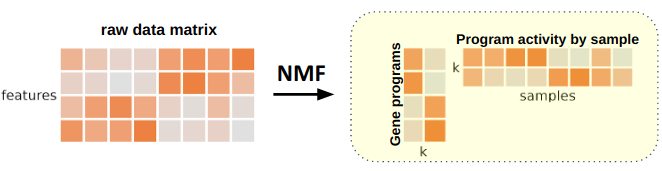

**After this workshop, we want you to feel comfortable with:**

* dimension reduction, denoising, and annotation of gene programs with NMF
* accessing sources of well-annotated single cell data, such as CELLxGENE
* how to fit new models and re-use existing models to explore new data


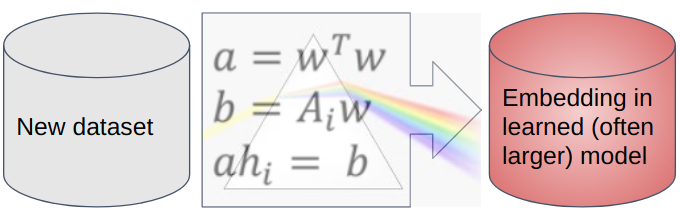


We are using Google Colab so you can share and hopefully build upon your work today. 

We'd love to see what you build with these tools in your own research!

#**Install necessary packages**

We need some packages for the code exercises in this workshop. 

Let's make sure we are running a reasonable operating system:

In [33]:
system("cat /etc/issue", intern=TRUE)

[1] "Ubuntu 20.04.5 LTS \\n \\l" ""

Let's also verify that the version of R running in colab is not too ancient.


In [1]:
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          3.0                         
year           2023                        
month          04                          
day            21                          
svn rev        84292                       
language       R                           
version.string R version 4.3.0 (2023-04-21)
nickname       Already Tomorrow            

OK, that's fine. Let's install some necessary packages. 

(It's a good idea to start this code running long before you need it!)

`devtools` in particular needs some system libraries installed with `sudo`.

In [2]:
system("sudo apt install python3-apt python3-dbus python3-gi libharfbuzz-dev libfribidi-dev", intern=TRUE)

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "python3-dbus is already the newest version (1.2.16-1build1)."     
[5] "python3-gi is already the newest version (3.36.0-1)."             
[6] "libfribidi-dev is already the newest version (1.0.8-2ubuntu0.1)." 
[7] "libharfbuzz-dev is already the newest version (2.6.4-1ubuntu4.2)."
[8] "python3-apt is already the newest version (2.0.1ubuntu0.20.04.1)."
[9] "0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded."

In [19]:
install.packages("devtools", quiet=TRUE)
if (suppressPackageStartupMessages(require("devtools"))) message("Verified that `devtools` is installed.")

Verified that `devtools` is installed.



We will also install `bspm` because it can substantially speed up this process.

In [21]:
suppressMessages(install.packages("bspm", quietly=TRUE))
if (require("bspm")) message("Verified that `bspm` is installed.")
bspm::disable()

Verified that `bspm` is installed.



In [22]:
suppressMessages(install.packages("remotes", quietly=TRUE))
if (require("remotes")) message("Verified that `remotes` is installed and loads.")

Verified that `remotes` is installed and loads.



In [25]:
suppressMessages(install.packages("BiocManager", quietly=TRUE))
if (require("BiocManager")) message("Verified that `BiocManager` is installed and loads.")

Verified that `BiocManager` is installed and loads.



In [26]:
suppressMessages(suppressWarnings(BiocManager::install("Seurat", update=TRUE, quiet=TRUE, ask=FALSE)))
if (require("Seurat")) message("Verified that `Seurat` is installed and loaded.")

Verified that `Seurat` is installed and loaded.



In [27]:
suppressMessages(suppressWarnings(BiocManager::install("iSEE", update=TRUE, quiet=TRUE, ask=FALSE)))
if (suppressPackageStartupMessages(require("iSEE", quietly=TRUE))) message("Verified that `iSEE` is installed and loaded.")

Verified that `iSEE` is installed and loaded.



The version of `RcppML` on GitHub is more recent than that on CRAN, so we'll use it for NMF-related calculations and manipulations.

In [28]:
suppressMessages(suppressWarnings(BiocManager::install("zdebruine/RcppML", quiet=TRUE)))
if (require("RcppML", quietly=TRUE)) message("Finished updating RcppML from GitHub.")

Finished updating RcppML from GitHub.



`singlet` requires the `fgsea` and `limma` packages from Bioconductor:

In [29]:
suppressMessages(suppressWarnings(BiocManager::install(c("fgsea", "limma"), quietly=TRUE)))
if (require("fgsea") & require("limma")) message("Verified that `fgsea` and `limma` are installed.")

Verified that `fgsea` and `limma` are installed.



Let's install `singlet` from GitHub, since that's currently where it lives.

In [38]:
devtools::install_github("zdebruine/singlet", force=TRUE)
if (require("singlet", quietly=TRUE)) message("Finished installing singlet from GitHub.")

Skipping 2 packages not available: fgsea, limma



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpDNa2FV/remotes176922182adec/zdebruine-singlet-765a6c4/DESCRIPTION’ ... OK
* preparing ‘singlet’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘singlet/data/pbmc3k.RData’
* building ‘singlet_0.99.26.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘/tmp/RtmpDNa2FV/file176922036959b/singlet_0.99.26.tar.gz’ had non-zero exit status”


Finally, since we're already installing a bunch of other packages, let's install the CELLxGENE Census API package (beta quality, in R).

Please note: this can take a long time! It's a good idea to run this **EARLY**.

In [42]:
if (require("bspm")) bspm::enable() # speeds things up a little bit
suppressMessages(suppressWarnings(BiocManager::install(c("arrow", "tiledb"))))
BiocManager::install("chanzuckerberg/cellxgene-census/api/r/cellxgene.census")
print(cellxgene.census::open_soma())

Tracing function "install.packages" in package "utils"




  There is a binary version available but the source version is later:
      binary source
arrow 10.0.1 12.0.0

  Binaries will be preferred


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Installing github package(s)
  'chanzuckerberg/cellxgene-census/api/r/cellxgene.census'

Skipping install of 'cellxgene.census' from a github remote, the SHA1 (e708d54d) has not changed since last install.
  Use `force = TRUE` to force installation

Old packages: 'arrow'

The stable Census release is currently 2023-05-15. Specify census_version = "2023-05-15" in future calls to open_soma() to ensure data consistency.



<SOMACollection>
  uri: s3://cellxgene-data-public/cell-census/2023-05-15/soma/ 
  groups: census_data*, census_info* 


That's enough package installation for one day. We will use all of these later in the workshop.

# A guided tour of NMF with Seurat and PBMC3K

[`Seurat`](https://satijalab.org/seurat/) ships with some excellent tutorials, a major reason for its success. Let's retrace the steps in one of them, using data from about 3000 peripheral blood mononuclear cells. Instead of principal components analysis, we will use non-negative matrix factorization (NMF) to denoise and compress the data. Some reasons why you might want to do such a thing can be found in [the FASTNMF paper](https://www.biorxiv.org/content/10.1101/2021.09.01.458620v1.full), but the short version is that we think it produces results which are usually easier to interpret than PCA. Caveat lector: use the best tool for _your_ experiment and design, whether or not that's NMF.

Output from the `singlet` example can also be found [here](https://https://zdebruine.github.io/singlet/articles/Guided_Clustering_with_NMF.html) if you want to check your work or just skip ahead a little bit.

In [48]:
# need to resolve installation ASAP!
library(singlet)

ERROR: ignored

# The CELLxGENE Discover tool

While using NMF on a decade-old single-cell RNAseq dataset is expedient, that's probably not what you came here to learn about. Fortunately, the explosion of single-cell transcriptomic, multi-omic, and spatial data has provided an awful lot of opportunities for data reuse and data integration. One of the best maintained, best annotated, and easiest places to start is the database housing the Human Cell Atlas, which has been renamed [CELLxGENE](https://cellxgene.cziscience.com/) (since it now has mouse and fish atlases, too). As microscopy and spatial transcriptomics starts to merge with single-cell suspension-based transcriptome and multiome work, you can expect to see more changes in the way that CELLxGENE organizes these results. For example, we are working with the fine folks at CZI to add a large (more or less complete) NMF model of gene programs operating in development directly into the CELLxGENE database. The hope is that by providing "gene program" activity alongside single-cell activity, both known and unknown genes and expression programs can be more rapidly studied and, eventually, their role in normal and abnormal development understood. Even if you don't want to write a single line of code or search a single database, though, you can use data from [all 50 million cells in CELLxGENE](https://cellxgene.cziscience.com/gene-expression) directly from the web.  (_Activity: tour CELLxGENE expression web with MBD2/MBD3 in brain cells_) 

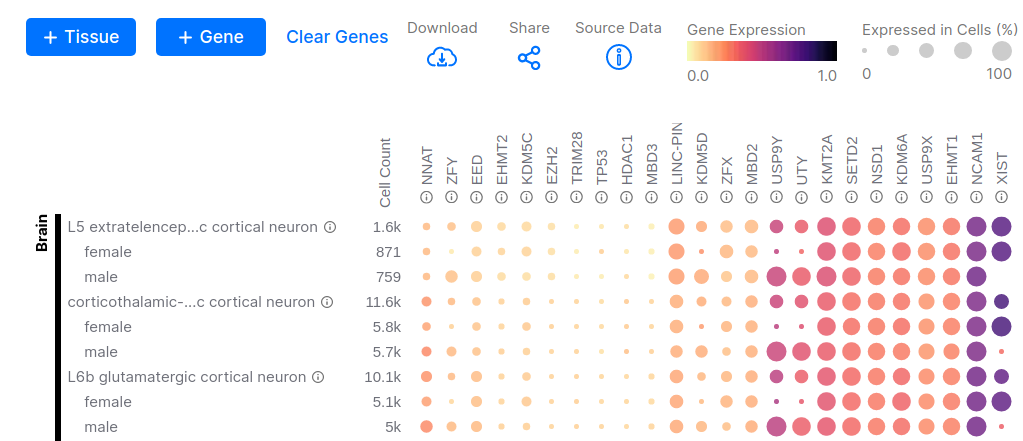

# SOMA, TileDb, and the CELLxGENE Census API

Even if all you could do with CELLxGENE was make dot plots of gene expression by tissue, sex, age, or disease, it would still be useful.

Fortunately, that is absolutely NOT the case! The underlying data and annotations for CELLxGENE are available directly from an Amazon Web Services S3 bucket, and as an added bonus, request (egress) is free. You can manipulate and model whatever subsets of the data you need, however you see fit, and if you want to integrate CELLxGENE data (Human Cell Atlas, Human Developmental Atlas, Tabula Muris, Tabula Muris Senis), you don't need to download anything beyond the cells you want, and your own data can stay where it is until you feel like sharing it with the world. The key to doing this efficiently is to use the CELLxGENE **Census** API, the R version of which we installed earlier.

Let's verify that the installation worked before we proceed further.

In [47]:
suppressMessages(suppressWarnings(BiocManager::install("chanzuckerberg/cellxgene-census/api/r/cellxgene.census")))
if (require("cellxgene.census")) message("The CELLxGENE Census R API is installed and loaded. Testing:")
print(cellxgene.census::open_soma())

The CELLxGENE Census R API is installed and loaded. Testing:

The stable Census release is currently 2023-05-15. Specify census_version = "2023-05-15" in future calls to open_soma() to ensure data consistency.



<SOMACollection>
  uri: s3://cellxgene-data-public/cell-census/2023-05-15/soma/ 
  groups: census_data*, census_info* 


**CELLxGENE and SOMA**

The central data structure in CELLxGENE is [**SOMA**](https://github.com/single-cell-data/SOMA), which is short for **S**tack **O**f **M**atrices, **A**nnotated. If you click on the preceding link, you'll find a formal schema for SOMA, which is represented like so:


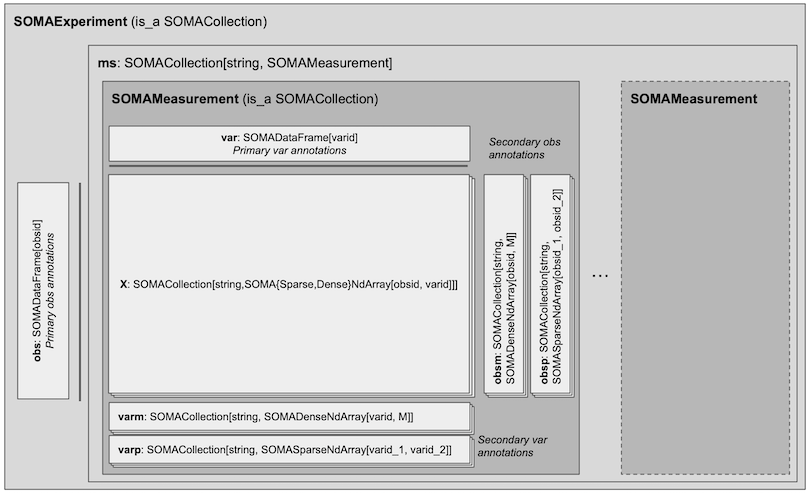

If you pull down a Census query into a variable conveniently called `SOMAExperiment`, you will find two key elements in your **SOMAExperiment**:

* `SOMAExperiment$ms` is a collection of named **SOMAMeasurement** objects (e.g., `RNA` or `ATAC` or `CITE`). Each can be queried by specimen, feature, or both. Usually you will only want a subset of the measurements.

* `SOMAExperiment$obs` is information about the specimens measured (i.e., the sample metadata). It can be turned into a data.frame (actually a `tibble`, for various reasons) if you need descriptive statistics. 

These are the two most important jumping-off points to explore CELLxGENE Census data using the R API.


**So, like, why don't you just store the matrices as CSV or MTX files?**

If you try to load tens of millions of cells directly into Python or R, you're going to have a bad time. If you don't keep track of which cell is which, you'll have an even worse time. SOMA helps avoid that. Although it may not be obvious, the above schema maps onto the familiar one below.

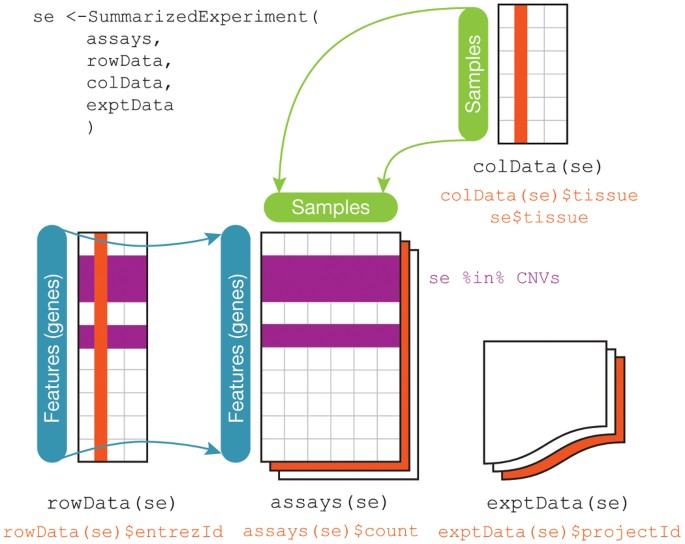


If you've used [Bioconductor](https://www.nature.com/articles/nmeth.3252#Fig2) at any time in the past quarter century, you'll notice that the same data structure underpins ExpressionSet and SummarizedExperiment objects -- there's a stack of matrices that hold the results of experiments, along with a data.frame holding information about the features (genes, peaks, loci, whatever) and another data.frame with information about the specimens (people, mice, time points, tissues, slices, etc). There's a reason this arrangement has stuck around: you want to keep data about the data (meta-data) in sync with the data itself, so you don't accidentally [kill people with Excel spreadsheets](https://www.nytimes.com/2011/07/08/health/research/08genes.html), or lose track of which mouse is which. So, let's stick with the tradition.


